# CD Projekt stock Monte Carlo simulation 

## Libraries

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")

## Dataset

In [175]:
cdr = pd.read_csv("cdr-moneypl-1583903568230.csv", parse_dates=True, index_col="Data")
cdr.head()

,Otwarcie,Zamknięcie,Maks.,Min.,Obrót (mln. zł),Zmiana (%)
Data,,,,,,
2020-03-10,276.0,270.3,280.0,268.0,109.42,0.00
2020-03-10,275.0,270.3,280.0,268.0,124.56,0.11
2020-03-09,266.0,270.0,284.0,259.5,191.21,-7.91
2020-03-06,294.6,293.2,294.9,283.0,104.89,-1.48
2020-03-05,303.0,297.6,305.5,294.2,90.58,0.68


## Summary stats

In [172]:
cdr_closing_returns = cdr["Zamknięcie"].pct_change().dropna()
average_cdr_closing_returns = np.mean(cdr_closing_returns)
std_cdr_closing_returns = np.std(cdr_closing_returns)
print("Average closing return:", average_cdr_closing_returns)
print("Standard deviation of closing returns:", std_cdr_closing_returns)
print("-"*100)
print("Annualized average closing return:", (1+average_cdr_closing_returns)**252-1)
print("Annualized standard deviation of closing returns:", std_cdr_closing_returns*np.sqrt(252))

Average closing return: 0.0004575329489688095
Standard deviation of closing returns: 0.04785141655942809
----------------------------------------------------------------------------------------------------
Annualized average closing return: 0.12217855548103884
Annualized standard deviation of closing returns: 0.7596176885904283


## Daily closing prices

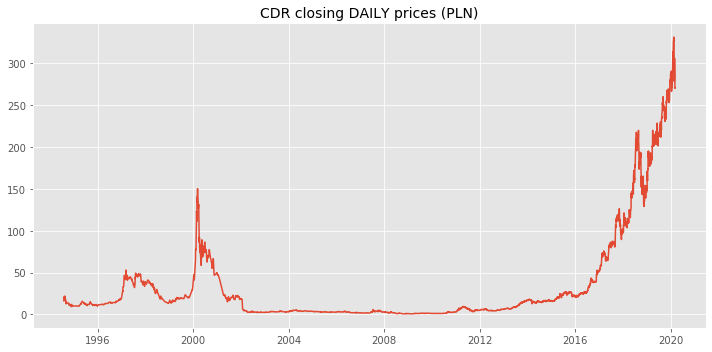

In [141]:
plt.figure(figsize=(10,5))
plt.plot(cdr["Zamknięcie"])
plt.title("CDR closing DAILY prices (PLN)", size=14)
plt.tight_layout()
plt.show()

### Daily returns

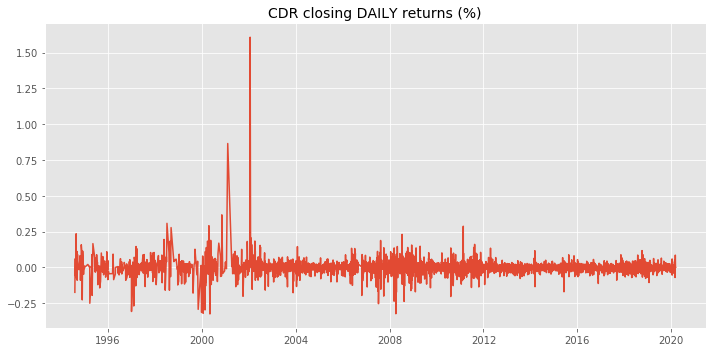

In [142]:
plt.figure(figsize=(10,5))
plt.plot(cdr_closing_returns)
plt.title("CDR closing DAILY returns (%)", size=14)
plt.tight_layout()
plt.show()

### Historical drawdown

In [6]:
cdr_closing_cumulative_returns = (1+cdr_closing_returns).cumprod()-1
running_max = np.maximum.accumulate(cdr_closing_cumulative_returns)
running_max[running_max < 1] = 1
drawdown = (cdr_closing_cumulative_returns)/running_max - 1
drawdown.max()

-0.7754347021827599

### Historical Value at Risk

In [7]:
var_level = 95
var = np.percentile(cdr_closing_returns, 100 - var_level)
print("Certaininty that daily losses will not exeed VaR% in a given day based on historical values.")
print("VaR 95%:", var)

Certaininty that daily losses will not exeed VaR% in a given day based on historical values.
VaR 95%: -0.05639981615480716


In [8]:
# var for the next 5 days
var * np.sqrt(5)

-0.12611382284063963

### Conditional historical Value at Risk

In [9]:
var_level = 95
var = np.percentile(cdr_closing_returns, 100 - var_level)
cvar = cdr_closing_returns[cdr_closing_returns < var].mean()
print("In the worst 5% of cases, losses were on average exceed % historically.")
print("CVaR 95%:", cvar)

In the worst 5% of cases, losses were on average exceed % historically.
CVaR 95%: -0.10227123180888698


### Monte Carlo simulation

In [164]:
days_ahead = 365
simulations = 2000
last_price = 270.3
results = np.empty((simulations, days_ahead))

for s in range(simulations):
    random_returns = 1 + np.random.normal(
        loc=average_cdr_closing_returns, scale=std_cdr_closing_returns, size=days_ahead)
    result = last_price * (random_returns.cumprod())
    results[s, :] = result

In [165]:
index = pd.date_range("2020-03-11", periods=days_ahead, freq="D")
results = pd.DataFrame(results.T, index=index)

### Monte Carlo results

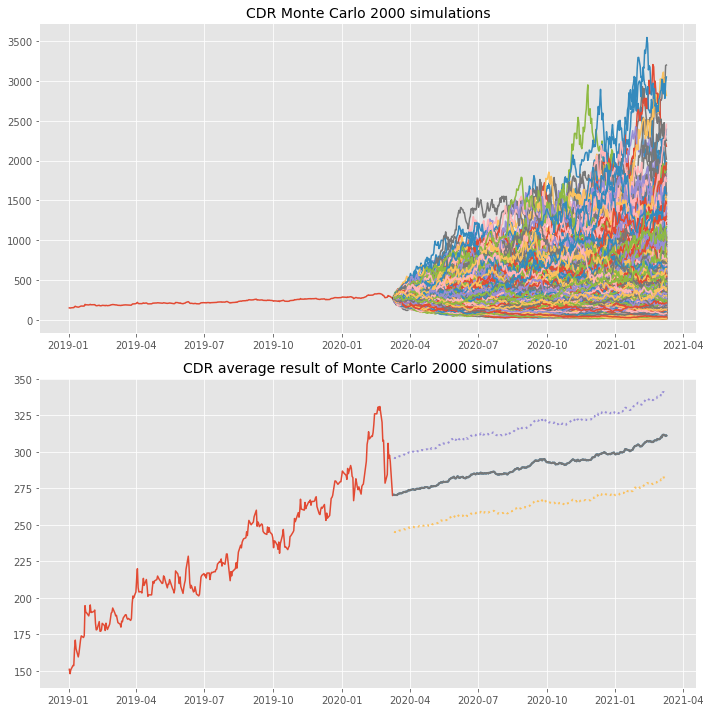

In [166]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

ax[0].plot(cdr["Zamknięcie"][:"2018-12-31"])
ax[0].plot(results)
ax[0].set_title(f"CDR Monte Carlo {simulations} simulations", size=14)
ax[1].plot(cdr["Zamknięcie"][:"2018-12-31"])
ax[1].plot(results.apply("mean", axis=1), lw=2)

results_average = results.apply("mean", axis=1)

ax[1].plot(results_average.apply(
    (lambda x: x * (1+1.96*std_cdr_closing_returns))), lw=2, linestyle="dotted")
ax[1].plot(results_average, lw=2)
ax[1].plot(results_average.apply(
    (lambda x: x * (1-1.96*std_cdr_closing_returns))), lw=2, linestyle="dotted")
ax[1].set_title(
    f"CDR average result of Monte Carlo {simulations} simulations", size=14)

plt.tight_layout()
plt.show()